In [13]:
from molmap import dataset
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, Concatenate,Flatten, Dense, Dropout


#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline
np.random.seed(777)
tf.set_random_seed(777)

In [14]:
def get_deepchem_idx(df):
    """ deepchem dataset"""
    deepchem_data_name = './BACE_deepchem.data'
    if os.path.exists(deepchem_data_name):
        train_df,valid_df,test_df = load(deepchem_data_name)
    else:
        import deepchem as dc
        task, train_valid_test, _ = dc.molnet.load_bace_classification(featurizer='Raw',split = 'scaffold')
        train, valid, test = train_valid_test
        train_df = df[df.smiles.isin(train.ids)]
        valid_df = df[df.smiles.isin(valid.ids)]
        test_df = df[df.smiles.isin(test.ids)]
        dump((train_df,valid_df,test_df), deepchem_data_name)
    train_idx = train_df.index
    valid_idx = valid_df.index
    test_idx = test_df.index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx


def get_attentiveFP_idx(df):
    """ attentiveFP dataset"""
    train, valid,test = load('./BACE_attentiveFP.data')
    train_idx = df[df.smiles.isin(train.mol)].index
    valid_idx = df[df.smiles.isin(valid.mol)].index
    test_idx = df[df.smiles.isin(test.mol)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 

#load dataset
data = dataset.load_BACE()
df = data.data

total samples: 1513


In [15]:
MASK = -1
Y = pd.DataFrame(data.y).fillna(MASK).values

In [16]:
# calculate feature
X1_name =  './descriptor_grid_split.data'
X2_name =  './fingerprint_grid_split.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp = loadmap('../../descriptor_grid_split.mp')
    X1 = mp.batch_transform(data.x, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp = loadmap('../../fingerprint_grid_split.mp')
    X2 = mp.batch_transform(data.x, n_jobs = 8)
    dump(X2, X2_name)

In [17]:
#train_idx, valid_idx, test_idx = get_attentiveFP_idx(df)
train_idx, valid_idx, test_idx = get_deepchem_idx(df)


trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]

print(len(train_idx), len(valid_idx), len(test_idx))

training set: 1210, valid set: 151, test set 152
1210 151 152


In [18]:
def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights

pos_weights, neg_weights = get_pos_weights(Y[train_idx])
pos_weights, neg_weights

(array([1.34951456]), array([0.74100719]))

In [19]:
def Inception(inputs, units = 8, strides = 1):
    """
    naive google inception block
    """
    x1 = Conv2D(units, 5, padding='same', activation = 'relu', strides = strides)(inputs)
    x2 = Conv2D(units, 3, padding='same', activation = 'relu', strides = strides)(inputs)
    x3 = Conv2D(units, 1, padding='same', activation = 'relu', strides = strides)(inputs)
    outputs = Concatenate()([x1, x2, x3])    
    return outputs


def DoublePathClassificationModel(molmap1_size, molmap2_size, n_outputs = 1):
    
    ## first inputs
    d_inputs1 = Input(molmap1_size)
    d_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(d_inputs1)
    d_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_conv1) #p1
    d_incept1 = Inception(d_pool1, strides = 1, units = 32)
    d_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(d_incept1) #p2
    d_incept2 = Inception(d_pool2, strides = 1, units = 64)
    d_flat1 = GlobalMaxPool2D()(d_incept2)

    
    ## second inputs
    f_inputs1 = Input(molmap2_size)
    f_conv1 = Conv2D(48, 13, padding = 'same', activation='relu', strides = 1)(f_inputs1)
    f_pool1 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_conv1) #p1
    f_incept1 = Inception(f_pool1, strides = 1, units = 32)
    f_pool2 = MaxPool2D(pool_size = 3, strides = 2, padding = 'same')(f_incept1) #p2
    f_incept2 = Inception(f_pool2, strides = 1, units = 64)
    f_flat1 = GlobalMaxPool2D()(f_incept2)    
    
    ## concat
    merge = Concatenate()([d_flat1, f_flat1]) 
    d1 = Dense(256,activation='relu')(merge)
    d1 = Dense(128,activation='relu')(d1)
    d1 = Dense(32,activation='relu')(d1)

    #since the sigmoid function is in loss function, so the activation function should be None
    outputs = Dense(n_outputs, activation=None)(d1)
    
    model = tf.keras.Model(inputs=[d_inputs1, f_inputs1], outputs=outputs)
    
    return model

from loss import cross_entropy, weighted_cross_entropy
from cbks import ClassificationPerformance, EarlyStoppingAtMinLoss

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]
loss = lambda y_true, y_pred: weighted_cross_entropy(y_true,y_pred, pos_weights, MASK)
model = DoublePathClassificationModel(molmap1_size,molmap2_size, n_outputs = Y.shape[1])

In [20]:
earlystop = EarlyStoppingAtMinLoss(patience=20, criteria = 'val_loss')
performace = ClassificationPerformance((trainX, trainY), (validX, validY), MASK)
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = loss)

In [21]:
model.fit(trainX, trainY, batch_size=128, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace, earlystop]) 

epoch: 0001, loss: 0.7966 - val_loss: 0.8220; auc: 0.8005 - auc_val: 0.5896                                                                                                    
epoch: 0002, loss: 0.7758 - val_loss: 0.8288; auc: 0.8366 - auc_val: 0.6052                                                                                                    
epoch: 0003, loss: 0.7543 - val_loss: 0.7921; auc: 0.8373 - auc_val: 0.6151                                                                                                    
epoch: 0004, loss: 0.7289 - val_loss: 0.7896; auc: 0.8505 - auc_val: 0.6306                                                                                                    
epoch: 0005, loss: 0.6985 - val_loss: 0.7748; auc: 0.8678 - auc_val: 0.6588                                                                                                    
epoch: 0006, loss: 0.6621 - val_loss: 0.7877; auc: 0.8765 - auc_val: 0.6612                                             

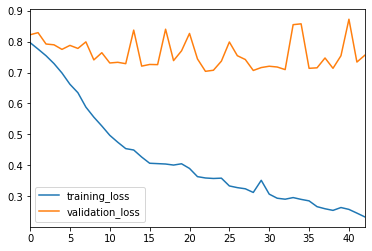

In [22]:
dfp = pd.DataFrame(performace.history)[['training_loss', 'validation_loss']]
dfp.plot()

In [23]:
train_auc = np.mean(performace.evaluate(trainX, trainY))
valid_auc = np.mean(performace.evaluate(validX, validY))
test_auc = np.mean(performace.evaluate(testX, testY))


print(train_auc, valid_auc, test_auc)

0.9519787665013619 0.7395167022032694 0.8536231884057971


In [24]:
performace.evaluate(testX, testY)

[0.8536231884057971]